# Build a geodataframe of multi-spec composite metadata
HLS compositing uses lots of scenes returned from EarthData queries.  Let's try to build and map a dataframe with that metadata

In [1]:
!pip install -U -r /projects/shared-buckets/montesano/requirements_main.txt

  Using cached pygeos-0.12.0-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (2.1 MB)
  Using cached Rtree-0.9.7-cp37-cp37m-manylinux2010_x86_64.whl (994 kB)
  Using cached geopandas-0.9.0-py2.py3-none-any.whl (994 kB)
  Using cached rasterio-1.2.6-cp37-cp37m-manylinux1_x86_64.whl (19.3 MB)
  Using cached importlib_resources-5.12.0-py3-none-any.whl (36 kB)
  Using cached contextily-1.3.0-py3-none-any.whl (16 kB)
  Using cached fsspec-2023.1.0-py3-none-any.whl (143 kB)
  Using cached s3fs-0.3.4-py3-none-any.whl (18 kB)
  Using cached rio_cogeo-2.3.1-py3-none-any.whl
  Using cached rio_tiler-2.1.4-py3-none-any.whl
  Using cached morecantile-2.1.4-py3-none-any.whl
  Using cached pystac_client-0.5.1-py3-none-any.whl (29 kB)
  Using cached cachetools-5.3.1-py3-none-any.whl (9.3 kB)
  Using cached pyproj-3.2.1-cp37-cp37m-manylinux2010_x86_64.whl (6.3 MB)
  Using cached click_plugins-1.1.1-py2.py3-none-any.whl (7.5 kB)
  Using cached cligj-0.7.2-py3-none-any.whl (7.1 kB)
  Using cac

In [51]:
!pip install plotnine
import sys
import os
sys.path.append('/projects/code/icesat2_boreal/lib')
sys.path.append('/projects/Developer/icesat2_boreal/lib')
#import ExtractUtils

import geopandas as gpd

import pandas as pd

import plotnine
from plotnine import *
import glob

import contextily as ctx

import json
import shapely

You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.


In [17]:
boreal_tiles_DAAC = gpd.read_file('/projects/my-public-bucket/boreal_tiles_v003_DAAC.gpkg')
boreal_tiles = gpd.read_file('/projects/my-public-bucket/databank/boreal_tiles_v003.gpkg')

In [18]:
boreal_tiles_DAAC.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 3891 entries, 0 to 3890
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   tile_num  3891 non-null   int64   
 1   geometry  3891 non-null   geometry
dtypes: geometry(1), int64(1)
memory usage: 60.9 KB


In [19]:
# This is the final list of HLS tiles that include the fixed (45) tiles
hls_params_fn = "s3://maap-ops-workspace/shared/nathanmthomas/DPS_tile_lists/HLS/c2020/HLS_stack_2022_v2/HLS_input_params.csv"

In [25]:
import s3fs

s3 = s3fs.S3FileSystem(anon=False)

# Fall 2022 c2020 composite
HLS_EXISTING_TINDEX_FN = 's3://maap-ops-workspace/shared/nathanmthomas/DPS_tile_lists/HLS/fall2022/HLS_stack_2022_v2/HLS_tindex_master.csv'
hls_tindex_master = pd.read_csv(HLS_EXISTING_TINDEX_FN)

In [21]:
hls_tindex_master.head()

,Unnamed: 0,s3_path,local_path,file,tile_num
0,5,s3://maap-ops-workspace/nathanmthomas/dps_outp...,/projects/my-private-bucket/dps_output/do_HLS_...,HLS_2490_06-15_09-01_2019_2021.tif,2490
1,4,s3://maap-ops-workspace/nathanmthomas/dps_outp...,/projects/my-private-bucket/dps_output/do_HLS_...,HLS_2423_06-15_09-01_2019_2021.tif,2423
2,3,s3://maap-ops-workspace/nathanmthomas/dps_outp...,/projects/my-private-bucket/dps_output/do_HLS_...,HLS_3067_06-15_09-01_2019_2021.tif,3067
3,2,s3://maap-ops-workspace/nathanmthomas/dps_outp...,/projects/my-private-bucket/dps_output/do_HLS_...,HLS_38592_06-01_09-15_2019_2021.tif,38592
4,1,s3://maap-ops-workspace/nathanmthomas/dps_outp...,/projects/my-private-bucket/dps_output/do_HLS_...,HLS_3866_06-01_09-15_2019_2021.tif,3866


In [29]:
TEST = False

In [30]:
if TEST:
    fn = hls_tindex_master.s3_path.to_list()[0]

    dirname = os.path.dirname(fn)
    tile_num =  os.path.basename(fn).split('_')[1]

    tile_json_fn = s3.glob(dirname + '/master_*_HLS.json')[0]

    f = s3.open(tile_json_fn, 'rb')
    data = json.load(f)
    data
    # gdf = gpd.GeoDataFrame.from_features(data["features"])
    # gdf.plot(alpha=0.005)
    # gdf.plot(column='eo:cloud_cover', alpha=0.25, cmap='RdYlGn_r', legend=True)

In [31]:
from multiprocessing import Pool
from functools import partial

In [32]:
list_s3_path = hls_tindex_master.s3_path.to_list()
print(list_s3_path[0])
os.path.basename(list_s3_path[0]).split('_')[1]

s3://maap-ops-workspace/nathanmthomas/dps_output/do_HLS_stack_3-1-2_ubuntu/HLS_stack_2022_v2/2022/10/21/21/04/29/648445/HLS_2490_06-15_09-01_2019_2021.tif


'2490'

In [33]:
def make_gdf_from_json(fn):
    
    dirname = os.path.dirname(fn)
    tile_num =  os.path.basename(fn).split('_')[1]
    
    tile_json_fn = s3.glob(dirname + '/master_*_HLS.json')[0]
    #print(tile_json_fn)
    f = s3.open(tile_json_fn, 'rb')
    data = json.load(f)
    
    # Build GDF
    gdf = gpd.GeoDataFrame.from_features(data["features"]).set_crs(4326)
    gdf['tile_num'] = tile_num
    
    # Build df
    df = pd.json_normalize(data, record_path=['features'])
    df['HLS_type'] = df['id'].str.split('.', 3, expand=True)[1]
    df['properties.datetime'] = pd.to_datetime(df['properties.datetime'], format= '%Y-%m-%d')
    df['year'] = df['properties.datetime'].dt.year
    df['month'] = df['properties.datetime'].dt.month
    df['doy'] = df['properties.datetime'].dt.dayofyear
    df['hour'] = df['properties.datetime'].dt.hour


    df['tile_num'] = tile_num
    df['filename'] = os.path.basename(fn)
    df['start'] = os.path.basename(fn).split('_')[2]
    df['end'] = os.path.basename(fn).split('_')[3]

    # Get smry of df
    df_smry = df.groupby(['tile_num','filename','start','end']).size().reset_index(name='counts')
    
    return gdf, df, df_smry

In [34]:
%%time
with Pool(processes=10) as pool:
    results = pool.map(partial(make_gdf_from_json), list_s3_path)

CPU times: user 25.1 s, sys: 3.95 s, total: 29.1 s
Wall time: 1min 55s


In [35]:
gdf_list = [result[0] for result in results]
gdf = pd.concat(gdf_list)
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 328801 entries, 0 to 17
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype   
---  ------          --------------   -----   
 0   geometry        328801 non-null  geometry
 1   datetime        328801 non-null  object  
 2   start_datetime  328801 non-null  object  
 3   end_datetime    328801 non-null  object  
 4   eo:cloud_cover  328801 non-null  int64   
 5   tile_num        328801 non-null  object  
dtypes: geometry(1), int64(1), object(4)
memory usage: 17.6+ MB


In [36]:
df_list = [result[1] for result in results]
df = pd.concat(df_list)
df.head()

,type,id,stac_version,stac_extensions,collection,bbox,links,geometry.type,geometry.coordinates,properties.datetime,...,assets.metadata.type,HLS_type,year,month,doy,hour,tile_num,filename,start,end
0,Feature,HLS.L30.T50VMR.2019166T032950.v2.0,1.0.0,[https://stac-extensions.github.io/eo/v1.0.0/s...,HLSL30.v2.0,"[115.014449, 63.027933, 117.199735, 64.02712]","[{'rel': 'self', 'href': 'https://cmr.earthdat...",Polygon,"[[[115.0228562, 63.0279332], [117.1929602, 63....",2019-06-15 03:29:50.315000+00:00,...,application/xml,L30,2019,6,166,3,2490,HLS_2490_06-15_09-01_2019_2021.tif,06-15,09-01
1,Feature,HLS.L30.T50VLR.2019166T033014.v2.0,1.0.0,[https://stac-extensions.github.io/eo/v1.0.0/s...,HLSL30.v2.0,"[114.923917, 63.026516, 115.217211, 63.394902]","[{'rel': 'self', 'href': 'https://cmr.earthdat...",Polygon,"[[[114.9239168, 63.026516], [115.2172106, 63.0...",2019-06-15 03:30:14.197000+00:00,...,application/xml,L30,2019,6,166,3,2490,HLS_2490_06-15_09-01_2019_2021.tif,06-15,09-01
2,Feature,HLS.L30.T50VMQ.2019166T033014.v2.0,1.0.0,[https://stac-extensions.github.io/eo/v1.0.0/s...,HLSL30.v2.0,"[115.016893, 62.13069, 117.193543, 63.129517]","[{'rel': 'self', 'href': 'https://cmr.earthdat...",Polygon,"[[[115.0815883, 62.1306897], [117.1872239, 62....",2019-06-15 03:30:14.197000+00:00,...,application/xml,L30,2019,6,166,3,2490,HLS_2490_06-15_09-01_2019_2021.tif,06-15,09-01
3,Feature,HLS.L30.T49VFL.2019166T033014.v2.0,1.0.0,[https://stac-extensions.github.io/eo/v1.0.0/s...,HLSL30.v2.0,"[114.895734, 62.981079, 115.202511, 63.4051]","[{'rel': 'self', 'href': 'https://cmr.earthdat...",Polygon,"[[[115.141383, 62.9810794], [115.2025111, 63.4...",2019-06-15 03:30:14.197000+00:00,...,application/xml,L30,2019,6,166,3,2490,HLS_2490_06-15_09-01_2019_2021.tif,06-15,09-01
4,Feature,HLS.L30.T49VFK.2019166T033014.v2.0,1.0.0,[https://stac-extensions.github.io/eo/v1.0.0/s...,HLSL30.v2.0,"[114.273825, 62.085587, 115.153839, 63.074248]","[{'rel': 'self', 'href': 'https://cmr.earthdat...",Polygon,"[[[115.0186771, 62.0855866], [115.1538391, 63....",2019-06-15 03:30:14.197000+00:00,...,application/xml,L30,2019,6,166,3,2490,HLS_2490_06-15_09-01_2019_2021.tif,06-15,09-01


In [37]:
df_smry_list = [result[2] for result in results]
df_smry = pd.concat(df_smry_list)
df_smry.info()
df_smry.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5245 entries, 0 to 0
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   tile_num  5245 non-null   object
 1   filename  5245 non-null   object
 2   start     5245 non-null   object
 3   end       5245 non-null   object
 4   counts    5245 non-null   int64 
dtypes: int64(1), object(4)
memory usage: 245.9+ KB


,tile_num,filename,start,end,counts
0,2490,HLS_2490_06-15_09-01_2019_2021.tif,06-15,09-01,177
0,2423,HLS_2423_06-15_09-01_2019_2021.tif,06-15,09-01,165
0,3067,HLS_3067_06-15_09-01_2019_2021.tif,06-15,09-01,185
0,38592,HLS_38592_06-01_09-15_2019_2021.tif,06-01,09-15,179
0,3866,HLS_3866_06-01_09-15_2019_2021.tif,06-01,09-15,159


In [38]:
df.head()

,type,id,stac_version,stac_extensions,collection,bbox,links,geometry.type,geometry.coordinates,properties.datetime,...,assets.metadata.type,HLS_type,year,month,doy,hour,tile_num,filename,start,end
0,Feature,HLS.L30.T50VMR.2019166T032950.v2.0,1.0.0,[https://stac-extensions.github.io/eo/v1.0.0/s...,HLSL30.v2.0,"[115.014449, 63.027933, 117.199735, 64.02712]","[{'rel': 'self', 'href': 'https://cmr.earthdat...",Polygon,"[[[115.0228562, 63.0279332], [117.1929602, 63....",2019-06-15 03:29:50.315000+00:00,...,application/xml,L30,2019,6,166,3,2490,HLS_2490_06-15_09-01_2019_2021.tif,06-15,09-01
1,Feature,HLS.L30.T50VLR.2019166T033014.v2.0,1.0.0,[https://stac-extensions.github.io/eo/v1.0.0/s...,HLSL30.v2.0,"[114.923917, 63.026516, 115.217211, 63.394902]","[{'rel': 'self', 'href': 'https://cmr.earthdat...",Polygon,"[[[114.9239168, 63.026516], [115.2172106, 63.0...",2019-06-15 03:30:14.197000+00:00,...,application/xml,L30,2019,6,166,3,2490,HLS_2490_06-15_09-01_2019_2021.tif,06-15,09-01
2,Feature,HLS.L30.T50VMQ.2019166T033014.v2.0,1.0.0,[https://stac-extensions.github.io/eo/v1.0.0/s...,HLSL30.v2.0,"[115.016893, 62.13069, 117.193543, 63.129517]","[{'rel': 'self', 'href': 'https://cmr.earthdat...",Polygon,"[[[115.0815883, 62.1306897], [117.1872239, 62....",2019-06-15 03:30:14.197000+00:00,...,application/xml,L30,2019,6,166,3,2490,HLS_2490_06-15_09-01_2019_2021.tif,06-15,09-01
3,Feature,HLS.L30.T49VFL.2019166T033014.v2.0,1.0.0,[https://stac-extensions.github.io/eo/v1.0.0/s...,HLSL30.v2.0,"[114.895734, 62.981079, 115.202511, 63.4051]","[{'rel': 'self', 'href': 'https://cmr.earthdat...",Polygon,"[[[115.141383, 62.9810794], [115.2025111, 63.4...",2019-06-15 03:30:14.197000+00:00,...,application/xml,L30,2019,6,166,3,2490,HLS_2490_06-15_09-01_2019_2021.tif,06-15,09-01
4,Feature,HLS.L30.T49VFK.2019166T033014.v2.0,1.0.0,[https://stac-extensions.github.io/eo/v1.0.0/s...,HLSL30.v2.0,"[114.273825, 62.085587, 115.153839, 63.074248]","[{'rel': 'self', 'href': 'https://cmr.earthdat...",Polygon,"[[[115.0186771, 62.0855866], [115.1538391, 63....",2019-06-15 03:30:14.197000+00:00,...,application/xml,L30,2019,6,166,3,2490,HLS_2490_06-15_09-01_2019_2021.tif,06-15,09-01


## Get a scenes-level data frame

### The number of HLS scenes used for this composite

In [39]:
df_scenes = df.groupby('id').aggregate({'id': 'count', 'properties.eo:cloud_cover': 'mean','year':'mean', 'start': 'first', 'end':'first', 'HLS_type': 'first', 'year': 'first', 'month': 'first', 'doy': 'first'}).rename(columns = {"id": "count"})
df_scenes.to_csv('/projects/my-public-bucket/boreal_polar_map/tables/mscomp_hls_scenes_smry.csv')
n_HLS_scenes = df_scenes.shape[0]
print(f'{n_HLS_scenes} scenes used in this composite')
df_scenes.head()

84209 scenes used in this composite


,count,properties.eo:cloud_cover,year,start,end,HLS_type,month,doy
id,,,,,,,,
HLS.L30.T01VCK.2020208T232307.v2.0,1,11,2020,07-01,09-01,L30,7,208
HLS.L30.T01VCK.2020224T232310.v2.0,1,29,2020,07-01,09-01,L30,8,224
HLS.L30.T01VCK.2021194T232306.v2.0,1,33,2021,07-01,09-01,L30,7,194
HLS.L30.T01VCL.2019230T231710.v2.0,2,37,2019,07-01,09-01,L30,8,230
HLS.L30.T01VCL.2019237T232259.v2.0,3,5,2019,07-01,09-01,L30,8,237


### Breakdown of num HLS scene per tile
dont get total scenes from this, because scenes overlap multiple tiles  
imperfect - not ass good as per-pixerl counts - but gives general sense of data availability across study domain

In [40]:
df_tile = df.groupby('tile_num').aggregate({'tile_num': 'count', 'properties.eo:cloud_cover': ['mean','max'], }).rename(columns = {"tile_num": "HLS_scenes"})
df_tile.columns = ['_'.join(col) for col in df_tile.columns]
df_tile.reset_index(inplace=True)
df_tile['tile_num'] = df_tile['tile_num'].astype(int)
df_tile.head()

,tile_num,HLS_scenes_count,properties.eo:cloud_cover_mean,properties.eo:cloud_cover_max
0,10,78,16.423077,40
1,100,45,12.266667,25
2,1000,80,3.787500,25
3,1001,102,2.960784,24
4,1002,98,3.632653,24


In [41]:
df_tile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5245 entries, 0 to 5244
Data columns (total 4 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   tile_num                        5245 non-null   int64  
 1   HLS_scenes_count                5245 non-null   int64  
 2   properties.eo:cloud_cover_mean  5245 non-null   float64
 3   properties.eo:cloud_cover_max   5245 non-null   int64  
dtypes: float64(1), int64(3)
memory usage: 164.0 KB


In [356]:
boreal_tiles_DAAC.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [42]:
boreal_tiles_DAAC_ = boreal_tiles_DAAC.merge(df_tile, on='tile_num')
boreal_tiles_DAAC_.to_file('/projects/my-public-bucket/databank/boreal_tiles_mscomp_c2020_hls_metadata.gpkg', driver='GPKG')

### Breakdown of HLS type
this is here for demo purposes - only `L30` used for c2020 composite

In [43]:
df_hls = df.groupby('HLS_type').aggregate({'HLS_type': 'count', 'properties.eo:cloud_cover': 'mean'}).rename(columns = {"HLS_type": "count"})
df_hls.head()

,count,properties.eo:cloud_cover
HLS_type,,
L30,328801,10.284777


In [44]:
df_scenes.head()

,count,properties.eo:cloud_cover,year,start,end,HLS_type,month,doy
id,,,,,,,,
HLS.L30.T01VCK.2020208T232307.v2.0,1,11,2020,07-01,09-01,L30,7,208
HLS.L30.T01VCK.2020224T232310.v2.0,1,29,2020,07-01,09-01,L30,8,224
HLS.L30.T01VCK.2021194T232306.v2.0,1,33,2021,07-01,09-01,L30,7,194
HLS.L30.T01VCL.2019230T231710.v2.0,2,37,2019,07-01,09-01,L30,8,230
HLS.L30.T01VCL.2019237T232259.v2.0,3,5,2019,07-01,09-01,L30,8,237


### Cloud cover analysis

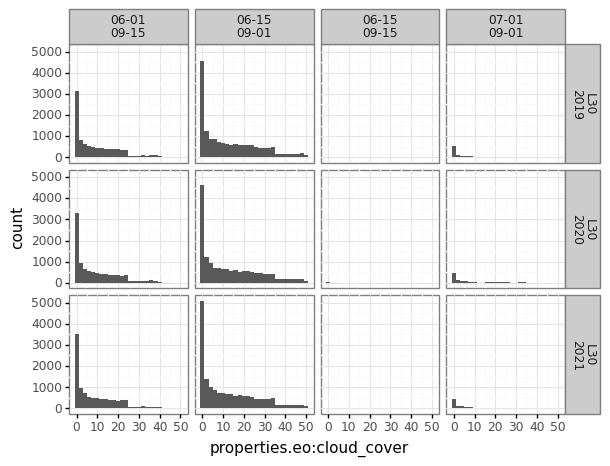

<ggplot: (8766843939893)>

In [302]:
var = 'properties.eo:cloud_cover'
(
    ggplot(data = df_scenes)
    + geom_histogram(aes(var), binwidth=2)
    + facet_grid('year + HLS_type~start + end')
    + theme(figure_size=(3, 4), axis_text_x=element_text(angle=45))  
    + theme_bw()
)

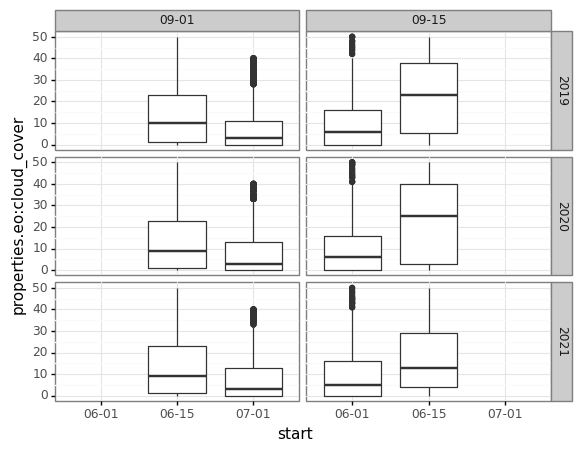

<ggplot: (8767154650353)>

In [260]:
(
    ggplot(data = df_scenes)
    #+ geom_point(aes(x='start', y=var))
    + geom_boxplot(aes(x='start', y=var))
    + facet_grid('year~end')
    + theme(figure_size=(3, 4), axis_text_x=element_text(angle=45))  
    + theme_bw()
)

In [391]:
df_scenes.info()

<class 'pandas.core.frame.DataFrame'>
Index: 84209 entries, HLS.L30.T01VCK.2020208T232307.v2.0 to HLS.L30.T60WWV.2021256T233438.v2.0
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   count                      84209 non-null  int64 
 1   properties.eo:cloud_cover  84209 non-null  int64 
 2   year                       84209 non-null  int64 
 3   start                      84209 non-null  object
 4   end                        84209 non-null  object
 5   HLS_type                   84209 non-null  object
 6   month                      84209 non-null  int64 
 7   doy                        84209 non-null  int64 
dtypes: int64(5), object(3)
memory usage: 5.8+ MB


### DOY analysis

In [48]:
from matplotlib import pyplot as plt
params = {'mathtext.default': 'regular' }          
plt.rcParams.update(params)
txt = '$x_{my text}$'
txt

'$x_{my text}$'

/opt/conda/lib/python3.7/site-packages/plotnine/stats/stat_bin.py:95: PlotnineWarning: 'stat_bin()' using 'bins = 53'. Pick better value with 'binwidth'.


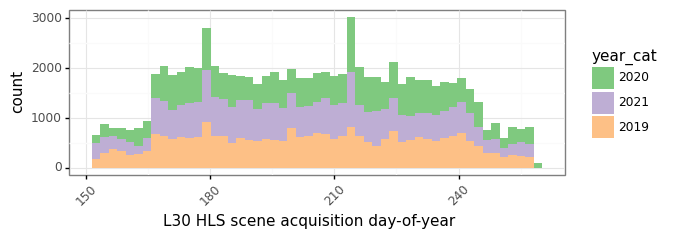

<ggplot: (8756759234821)>

In [50]:
df_scenes['year_cat'] = pd.Categorical(df_scenes.year, categories=pd.unique(df_scenes.year))
(
    ggplot(data = df_scenes)

    + geom_histogram(aes(x='doy', fill='year_cat'), position = position_stack() )
    + facet_grid('~start+end')
    + scale_fill_brewer(palette=1, type='qual')
    + labs(x='HLS scene acquisition day-of-year')
    + theme_bw()
    + theme(figure_size=(6, 1), axis_text_x=element_text(angle=45))  
    
)

(
    ggplot(data = df_scenes)

    + geom_histogram(aes(x='doy', fill='year_cat'), position = position_stack() )
    #+ facet_grid('~year_cat')
    + scale_fill_brewer(palette=1, type='qual')
    + labs(x='L30 HLS scene acquisition day-of-year')
    + theme_bw()
    + theme(
            aspect_ratio=1/3,
            #figure_size=(6, 1), 
            axis_text_x=element_text(angle=45)
           )  
    
)

In [344]:
df.head()

,type,id,stac_version,stac_extensions,collection,bbox,links,geometry.type,geometry.coordinates,properties.datetime,...,assets.metadata.type,HLS_type,year,month,doy,hour,tile_num,filename,start,end
0,Feature,HLS.L30.T50VMR.2019166T032950.v2.0,1.0.0,[https://stac-extensions.github.io/eo/v1.0.0/s...,HLSL30.v2.0,"[115.014449, 63.027933, 117.199735, 64.02712]","[{'rel': 'self', 'href': 'https://cmr.earthdat...",Polygon,"[[[115.0228562, 63.0279332], [117.1929602, 63....",2019-06-15 03:29:50.315000+00:00,...,application/xml,L30,2019,6,166,3,2490,HLS_2490_06-15_09-01_2019_2021.tif,06-15,09-01
1,Feature,HLS.L30.T50VLR.2019166T033014.v2.0,1.0.0,[https://stac-extensions.github.io/eo/v1.0.0/s...,HLSL30.v2.0,"[114.923917, 63.026516, 115.217211, 63.394902]","[{'rel': 'self', 'href': 'https://cmr.earthdat...",Polygon,"[[[114.9239168, 63.026516], [115.2172106, 63.0...",2019-06-15 03:30:14.197000+00:00,...,application/xml,L30,2019,6,166,3,2490,HLS_2490_06-15_09-01_2019_2021.tif,06-15,09-01
2,Feature,HLS.L30.T50VMQ.2019166T033014.v2.0,1.0.0,[https://stac-extensions.github.io/eo/v1.0.0/s...,HLSL30.v2.0,"[115.016893, 62.13069, 117.193543, 63.129517]","[{'rel': 'self', 'href': 'https://cmr.earthdat...",Polygon,"[[[115.0815883, 62.1306897], [117.1872239, 62....",2019-06-15 03:30:14.197000+00:00,...,application/xml,L30,2019,6,166,3,2490,HLS_2490_06-15_09-01_2019_2021.tif,06-15,09-01
3,Feature,HLS.L30.T49VFL.2019166T033014.v2.0,1.0.0,[https://stac-extensions.github.io/eo/v1.0.0/s...,HLSL30.v2.0,"[114.895734, 62.981079, 115.202511, 63.4051]","[{'rel': 'self', 'href': 'https://cmr.earthdat...",Polygon,"[[[115.141383, 62.9810794], [115.2025111, 63.4...",2019-06-15 03:30:14.197000+00:00,...,application/xml,L30,2019,6,166,3,2490,HLS_2490_06-15_09-01_2019_2021.tif,06-15,09-01
4,Feature,HLS.L30.T49VFK.2019166T033014.v2.0,1.0.0,[https://stac-extensions.github.io/eo/v1.0.0/s...,HLSL30.v2.0,"[114.273825, 62.085587, 115.153839, 63.074248]","[{'rel': 'self', 'href': 'https://cmr.earthdat...",Polygon,"[[[115.0186771, 62.0855866], [115.1538391, 63....",2019-06-15 03:30:14.197000+00:00,...,application/xml,L30,2019,6,166,3,2490,HLS_2490_06-15_09-01_2019_2021.tif,06-15,09-01


In [269]:
boreal_tiles_DAAC.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [101]:
#ax = gdf.cx[-175:-100,40:75].plot(alpha=0.005, figsize=(20,8))
#ax = gdf.set_crs(4326).to_crs(3995).plot(alpha=0.005, figsize=(20,20))
#boreal_tiles_DAAC.to_crs(3995).boundary.plot(ax=ax, alpha=0.25, ec='red')
#ctx.add_basemap(ax=ax, source = )

<AxesSubplot:>

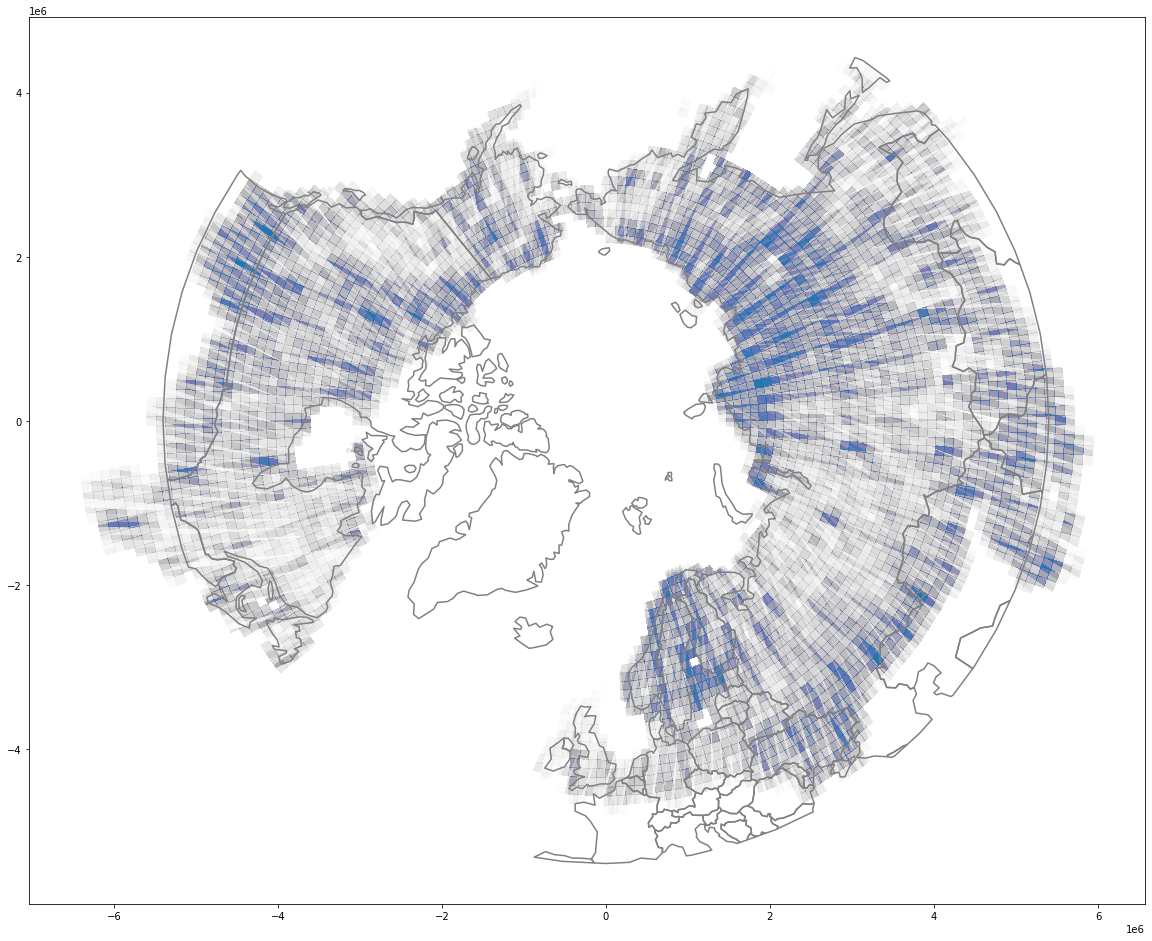

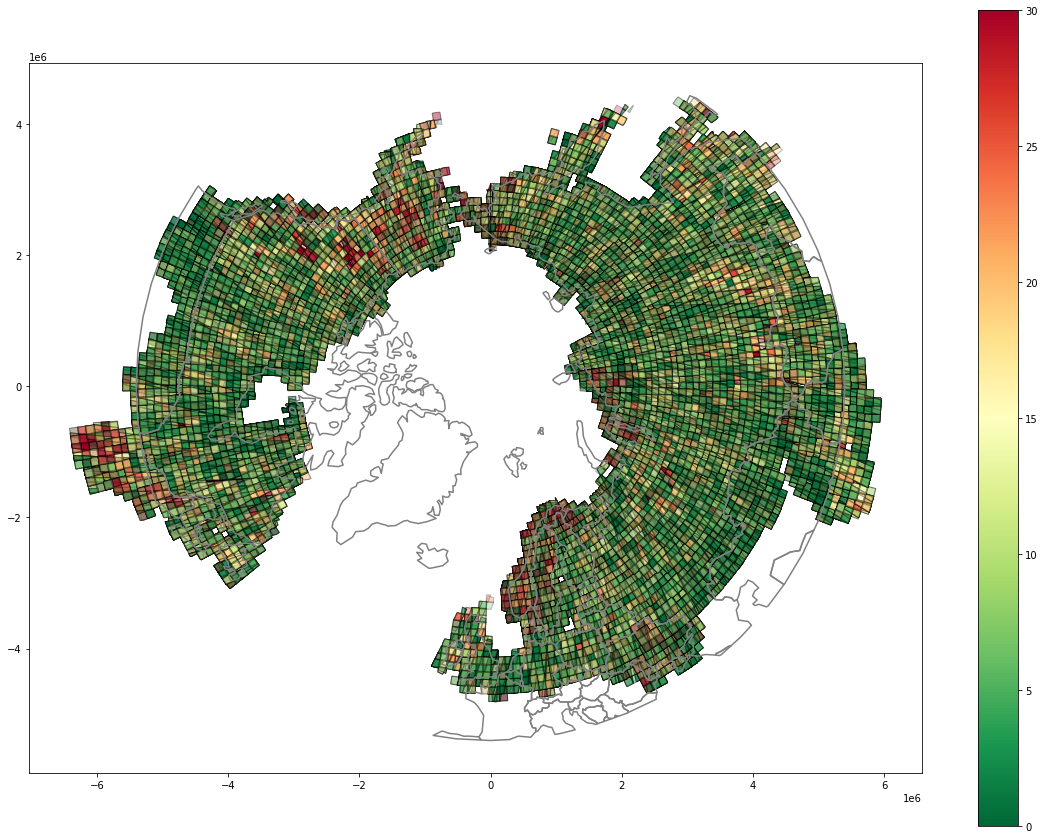

In [100]:
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
#world_clip_box = gpd.clip(world, shapely.geometry.box(-180, 45, 180, 88) )
circle = shapely.geometry.Point(float(0), float(0)).buffer(5.4e6)
world_clip_circle = gpd.clip(world.to_crs(3995), circle )
world_clip_circle['area'] = world_clip_circle.geometry.area
world_clip_circle_subset = world_clip_circle[world_clip_circle.area != max(world_clip_circle.area)]
ax = gdf.set_crs(4326).to_crs(3995).plot(alpha=0.005, figsize=(20,20))
world_clip_circle_subset.boundary.plot(ec='k', color='gray', alpha=1, figsize=(20,15), ax=ax)

ax = gdf.set_crs(4326).to_crs(3995).plot(column='eo:cloud_cover', alpha=0.25, cmap='RdYlGn_r', legend=True, ec='k', figsize=(20,15), vmin=0, vmax=30)
#ax = boreal_tiles_DAAC.to_crs(3995).boundary.plot(alpha=0.25, ec='red')
world_clip_circle_subset.boundary.plot(ec='k', color='gray', alpha=1, figsize=(20,15), ax=ax)